In [199]:
# from pybaseball import playerid_reverse_lookup, player_search_list
from helper import split_name, calc_fantasy_points_batting, calc_fantasy_points_pitching, get_value_before_comma
from read_data import cast_feature_dtypes, pull_data, pull_projections
from modeling import split_data, create_baseline, tune_xgb, create_model, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, calculate_relative_value, determine_optimal_k, segment_players
from config import AGG_YEARS, batting_stat_cols, pitching_stat_cols, batting_agg_cols, pitching_agg_cols, POS_DAMPENING_MAP
from hyperopt import hp
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

START_YEAR = 2005 # <- Beginning season for data pull
END_YEAR = 2025 # <- Ending season for data pull, final model will predict following season
MODEL_WEIGHT = 0.69
PROJECTION_WEIGHT = 1 - MODEL_WEIGHT
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.15
PITCHER_SPLIT = 0.34
BATTER_SPLIT_IF = 0.33
BATTER_SPLIT_OF = 0.33

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

In [148]:
# Pull data for batters & pitchers
batting_df, pitching_df = pull_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_agg_cols=batting_agg_cols,
    pitching_agg_cols=pitching_agg_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
)

# Casting feature dtypes for batting & pitching dataframes
batting_df = cast_feature_dtypes(batting_df)
pitching_df = cast_feature_dtypes(pitching_df)

# Filtering pitchers from batting_df, they should not be included in the batter model
batting_df = batting_df[batting_df["pos_type"] != "Pitcher"].copy()
# Dropping pos_type and primary_pos from pitching_df as they are redundant (every player is a pitcher)
pitching_df = pitching_df.drop(columns=["pos_type", "primary_pos"]).copy()

# Defining the prediction data for batters & pitchers
batting_pred = batting_df[batting_df["Season"] == END_YEAR].copy()
pitching_pred = pitching_df[pitching_df["Season"] == END_YEAR].copy()
# Dropping the prediction year from the training data
batting_df = batting_df[batting_df["Season"] < END_YEAR].copy()
pitching_df = pitching_df[pitching_df["Season"] < END_YEAR].copy()

# Filter out players with 0 future fantasy points (would not be fantasy draft eligible regardless)
batting_df = batting_df[batting_df["fantasy_points_future"] > 0].copy()
pitching_df = pitching_df[pitching_df["fantasy_points_future"] > 0].copy()

C:\Users\jorda\Documents\development\baseball_modeling\read_data.py:656: DtypeWarning: Columns (173) have mixed types. Specify dtype option on import or set low_memory=False.
C:\Users\jorda\Documents\development\baseball_modeling\read_data.py:657: DtypeWarning: Columns (170) have mixed types. Specify dtype option on import or set low_memory=False.


Loaded existing data files.


# Pulling FantasyPros Projection Data

In [149]:
batting_projections = pull_projections(batting_url)
# Replace NaN values in the "Positions" column with "DH" for hitters
batting_projections['Positions'] = batting_projections['Positions'].fillna('DH')
# Calculating projected number of singles
batting_projections['1B'] = batting_projections['H'] - batting_projections['2B'] - batting_projections['3B'] - batting_projections['HR']
# Each player will receive 6 projected HBP by default (average number of HBP per season for batters with at least 100 games played)
batting_projections['HBP'] = 6
# Calculating batting fantasy point projection
batting_projections = calc_fantasy_points_batting(batting_projections, 'projected_fantasy_points')
# Selecting relevant columns
batting_projections = batting_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

pitching_projections = pull_projections(pitching_url)
# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_projections['Positions'] = pitching_projections['Positions'].fillna('SP')
# Renaming the "K" column to "SO" for pitchers
pitching_projections = pitching_projections.rename(columns={'K': 'SO'})
# Calculating pitching fantasy point projection
pitching_projections = calc_fantasy_points_pitching(pitching_projections, 'projected_fantasy_points')
# Selecting relevant columns
pitching_projections = pitching_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

In [150]:
display(batting_projections.head())

first_name last_name Team    Positions  projected_fantasy_points
0     shohei    ohtani  LAD        SP,DH                      1777
1      aaron     judge  NYY  LF,CF,RF,DH                      1748
2      bobby      witt   KC           SS                      1567
3       juan      soto  NYM        LF,RF                      1652
4     ronald     acuna  ATL           RF                      1532

# Creating Batting Model

## Creating baseline batting predictions

In [151]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df, random_state=42022)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 261.850 | MAE: 204.077 | R^2: 0.643


In [152]:
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp)

Name  fantasy_points_future  predicted_fantasy_points  \
715    Alex Rodriguez                 2062.0               1724.363892   
1133   Bobby Witt Jr.                 1834.0               1719.269165   
1188     David Wright                 1805.0               1686.891235   
24     Grady Sizemore                 1761.0               1684.987671   
171    Prince Fielder                 1826.0               1682.516235   
...               ...                    ...                       ...   
821        Jose Osuna                  131.0                112.545296   
1214  Grayson Greiner                   89.0                104.109123   
1332    Yadiel Rivera                   87.0                 88.240028   
370       Jake Elmore                  144.0                 80.513451   
677       Jeff Larish                  175.0                 68.492287   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
715       -337.636108     337.636108    2006   30            1648  
1133      -114.730835     114.730835    2023   23            1594  
1188      -118.108765     118.108765    2006   23            1587  
24         -76.012329      76.012329    2005   22            1524  
171       -143.483765     143.483765    2008   24            1500  
...               ...            ...     ...  ...             ...  
821        -18.454704      18.454704    2019   26             548  
1214        15.109123      15.109123    2019   26             297  
1332         1.240028       1.240028    2018   26             197  
370        -63.486549      63.486549    2015   28             208  
677       -106.507713     106.507713    2008   25             198  

[1590 rows x 8 columns]

# Building Final Model

In [153]:
# MAX_DEPTH_CHOICES = [4, 5, 6, 7]

# space = {
#     "learning_rate": hp.loguniform("learning_rate", np.log(0.025), np.log(0.2)),
#     "max_depth": hp.choice("max_depth", MAX_DEPTH_CHOICES),
#     "subsample": hp.uniform("subsample", 0.7, 1.00),
#     "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 1.0),

#     "min_child_weight": hp.loguniform("min_child_weight", np.log(1.0), np.log(12.0)),
#     "reg_lambda": hp.loguniform("reg_lambda", np.log(0.5), np.log(12.0)),
#     "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-3), np.log(3.0)),
#     "gamma": hp.loguniform("gamma", np.log(1e-3), np.log(2.0)),
# }

In [154]:
space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.02), np.log(0.08)),

    # leaf-based complexity control
    "max_leaves": hp.quniform("max_leaves", 8, 96, 1),

    "subsample": hp.uniform("subsample", 0.70, 1.00),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.65, 1.00),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(0.5), np.log(8.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(1e-5), np.log(5.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-3), np.log(5.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-4), np.log(1.0)),
}

# Batting Predictions

In [155]:
# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=45,
    random_state=4202022,
    id_cols=["IDfg"],
    max_depth_choices=None,
)

100%|██████████| 45/45 [03:45<00:00,  5.01s/trial, best loss: 264.4124657790515] 
Best Parameters: {'learning_rate': 0.032520921356719384, 'max_leaves': 8, 'grow_policy': 'lossguide', 'max_depth': 0, 'subsample': 0.7945185240660698, 'colsample_bytree': 0.8384130033816877, 'min_child_weight': 5.33335775254934, 'reg_lambda': 0.24792213795815718, 'reg_alpha': 0.4068264942560152, 'gamma': 0.001590220534009798}
[Best trial @ val] optimized=rmse | RMSE=264.412 | MAE=203.428 | ASYM=86954.904


In [156]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=42020,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 339
[Val] RMSE: 267.033 | MAE: 205.905 | R^2: 0.639 | ASYM: 88742.995
[Test] RMSE: 259.174 | MAE: 203.548 | R^2: 0.651 | ASYM: 84314.654


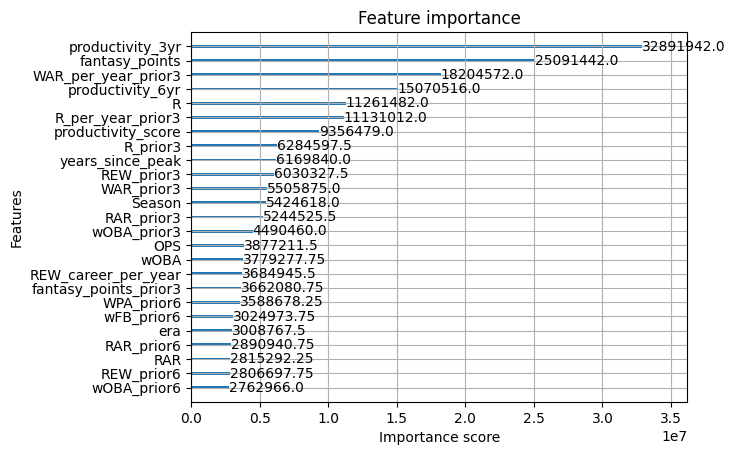

In [157]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=25)
plt.show()

In [158]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results)

Name  fantasy_points_future  predicted_fantasy_points  \
41        Aaron Judge                 1185.0               1766.959961   
1188     David Wright                 1805.0               1622.744629   
715    Alex Rodriguez                 2062.0               1618.737671   
24     Grady Sizemore                 1761.0               1617.443359   
1133   Bobby Witt Jr.                 1834.0               1611.321533   
...               ...                    ...                       ...   
204       Jeff Mathis                  108.0                 84.624077   
1500   Alex Dickerson                  404.0                 70.951210   
714      Andrew Knapp                  187.0                 63.665203   
669       Pat Valaika                  289.0                 55.176540   
1214  Grayson Greiner                   89.0                 50.229355   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
41         581.959961     581.959961    2022   30            1992  
1188      -182.255371     182.255371    2006   23            1587  
715       -443.262329     443.262329    2006   30            1648  
24        -143.556641     143.556641    2005   22            1524  
1133      -222.678467     222.678467    2023   23            1594  
...               ...            ...     ...  ...             ...  
204        -23.375923      23.375923    2019   36             256  
1500      -333.048790     333.048790    2019   29             403  
714       -123.334797     123.334797    2019   27             231  
669       -233.823460     233.823460    2019   26             123  
1214       -38.770645      38.770645    2019   26             297  

[1590 rows x 8 columns]

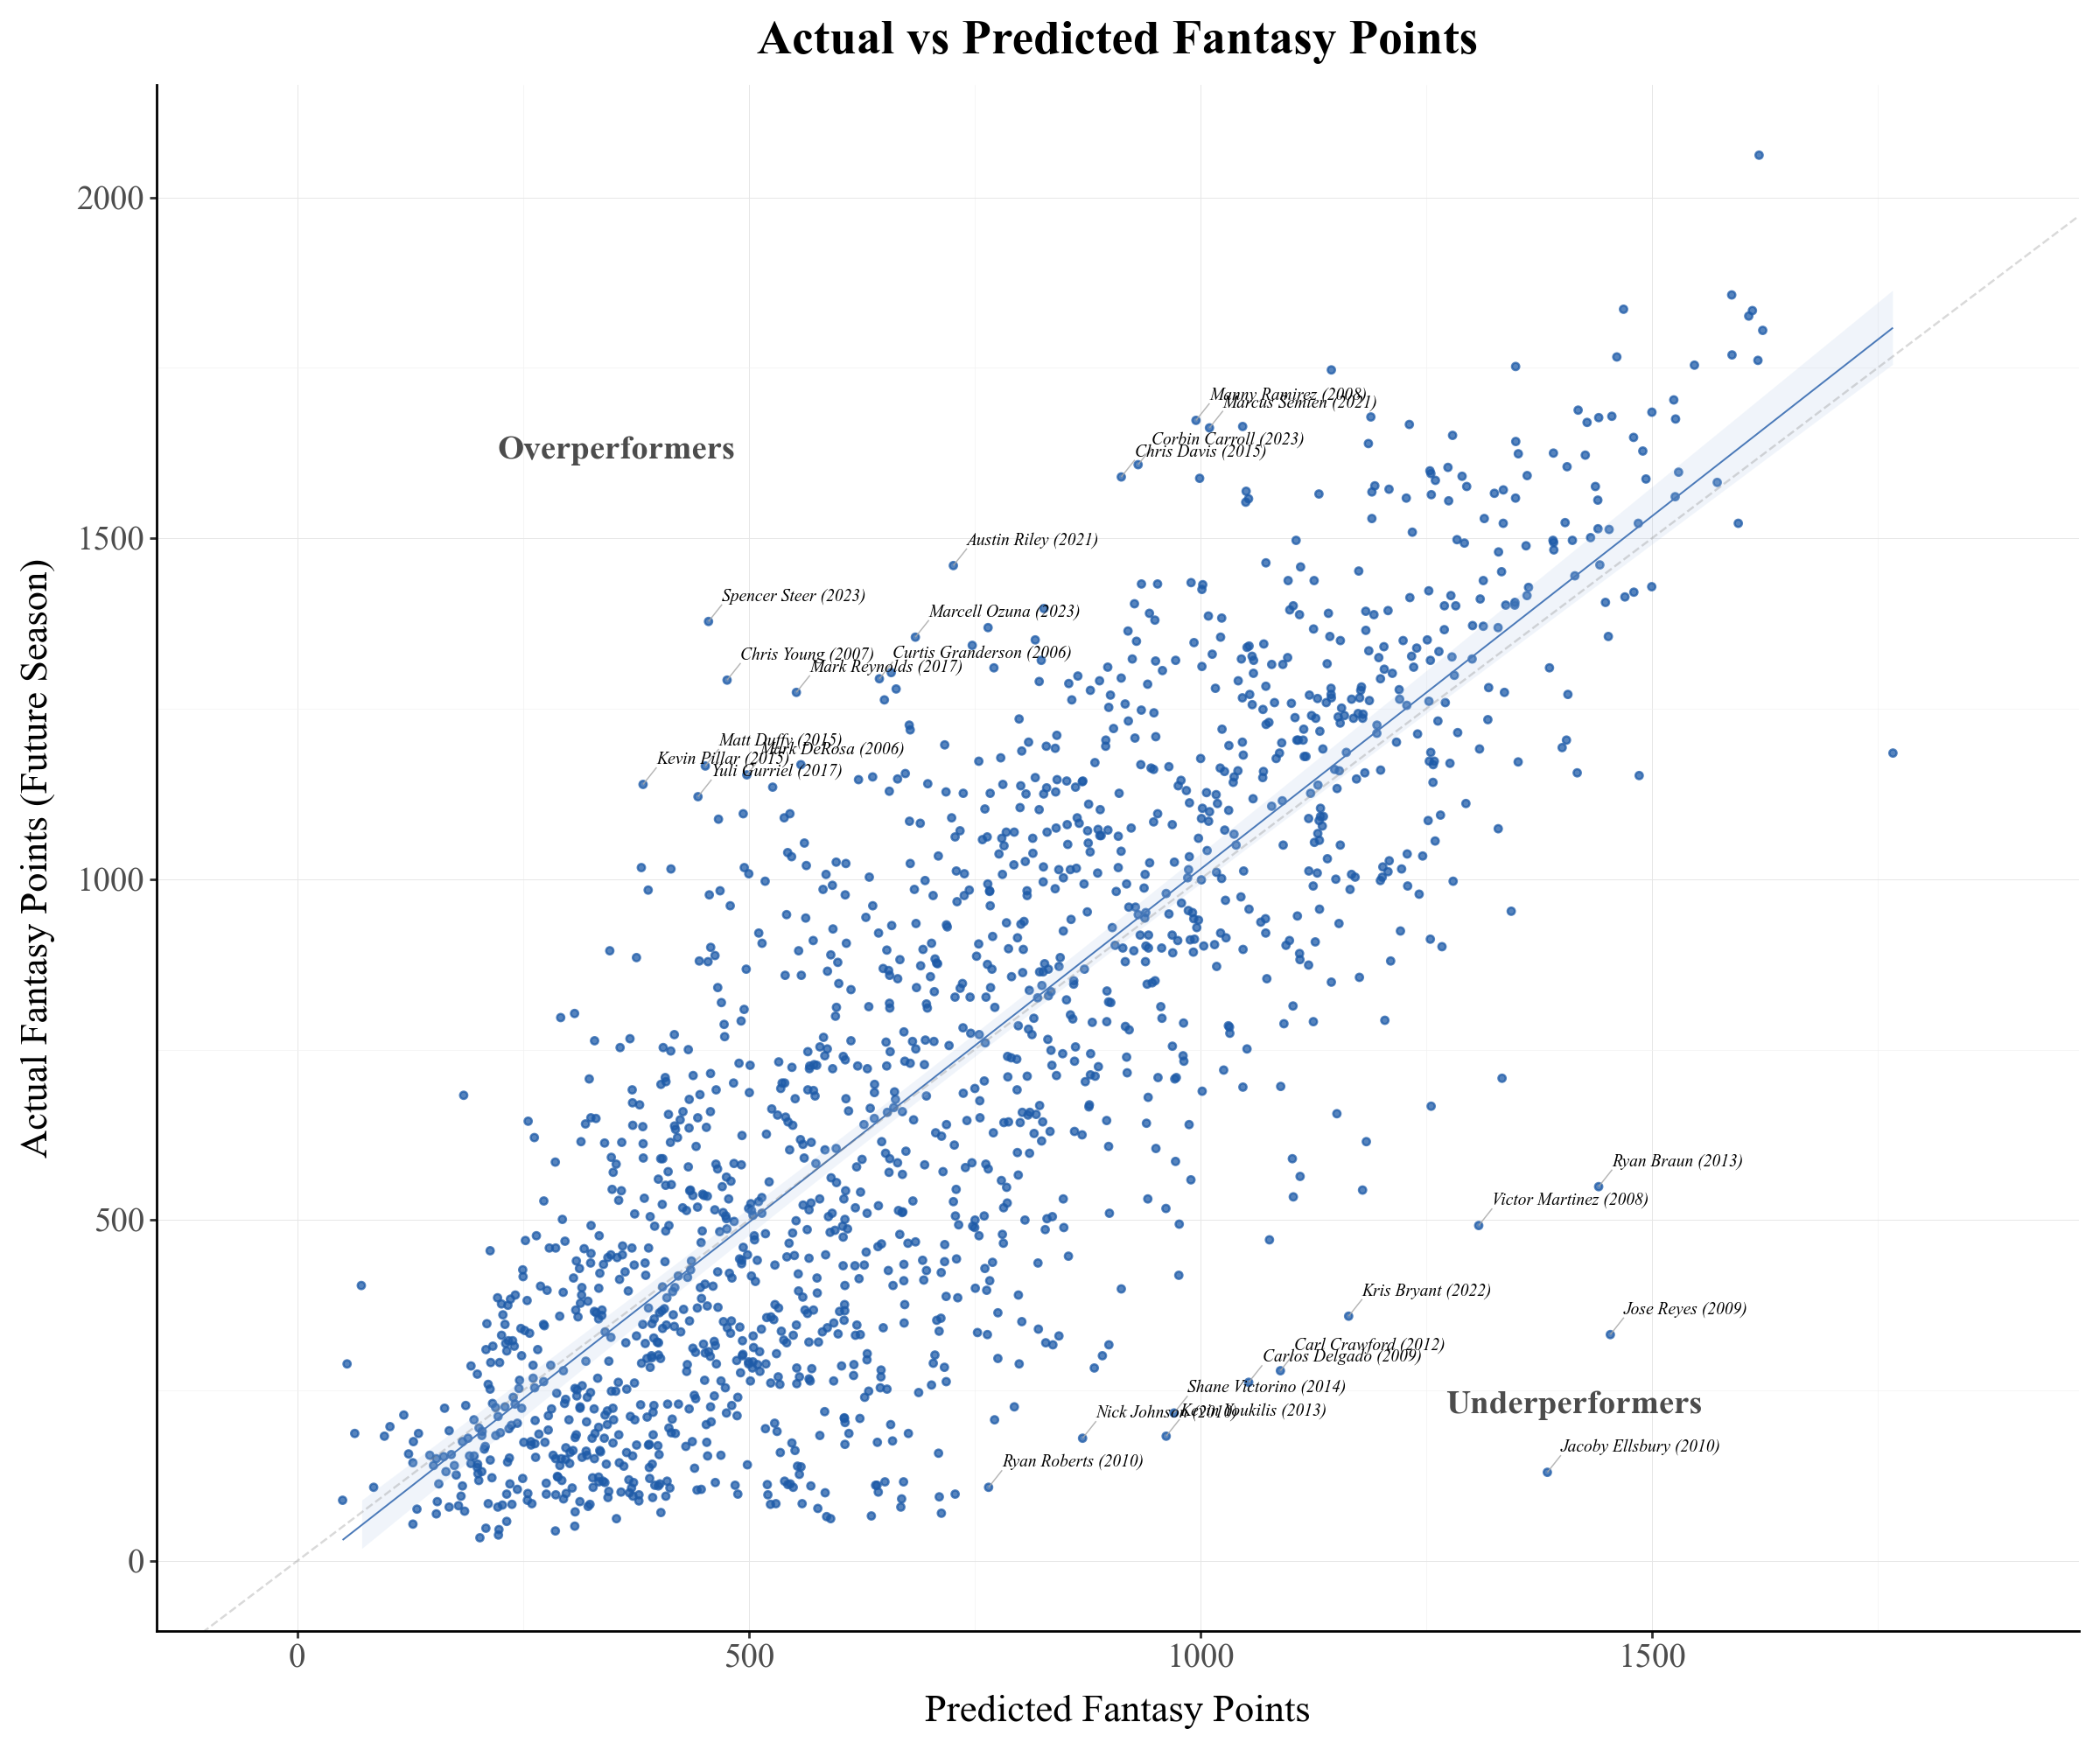

In [159]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

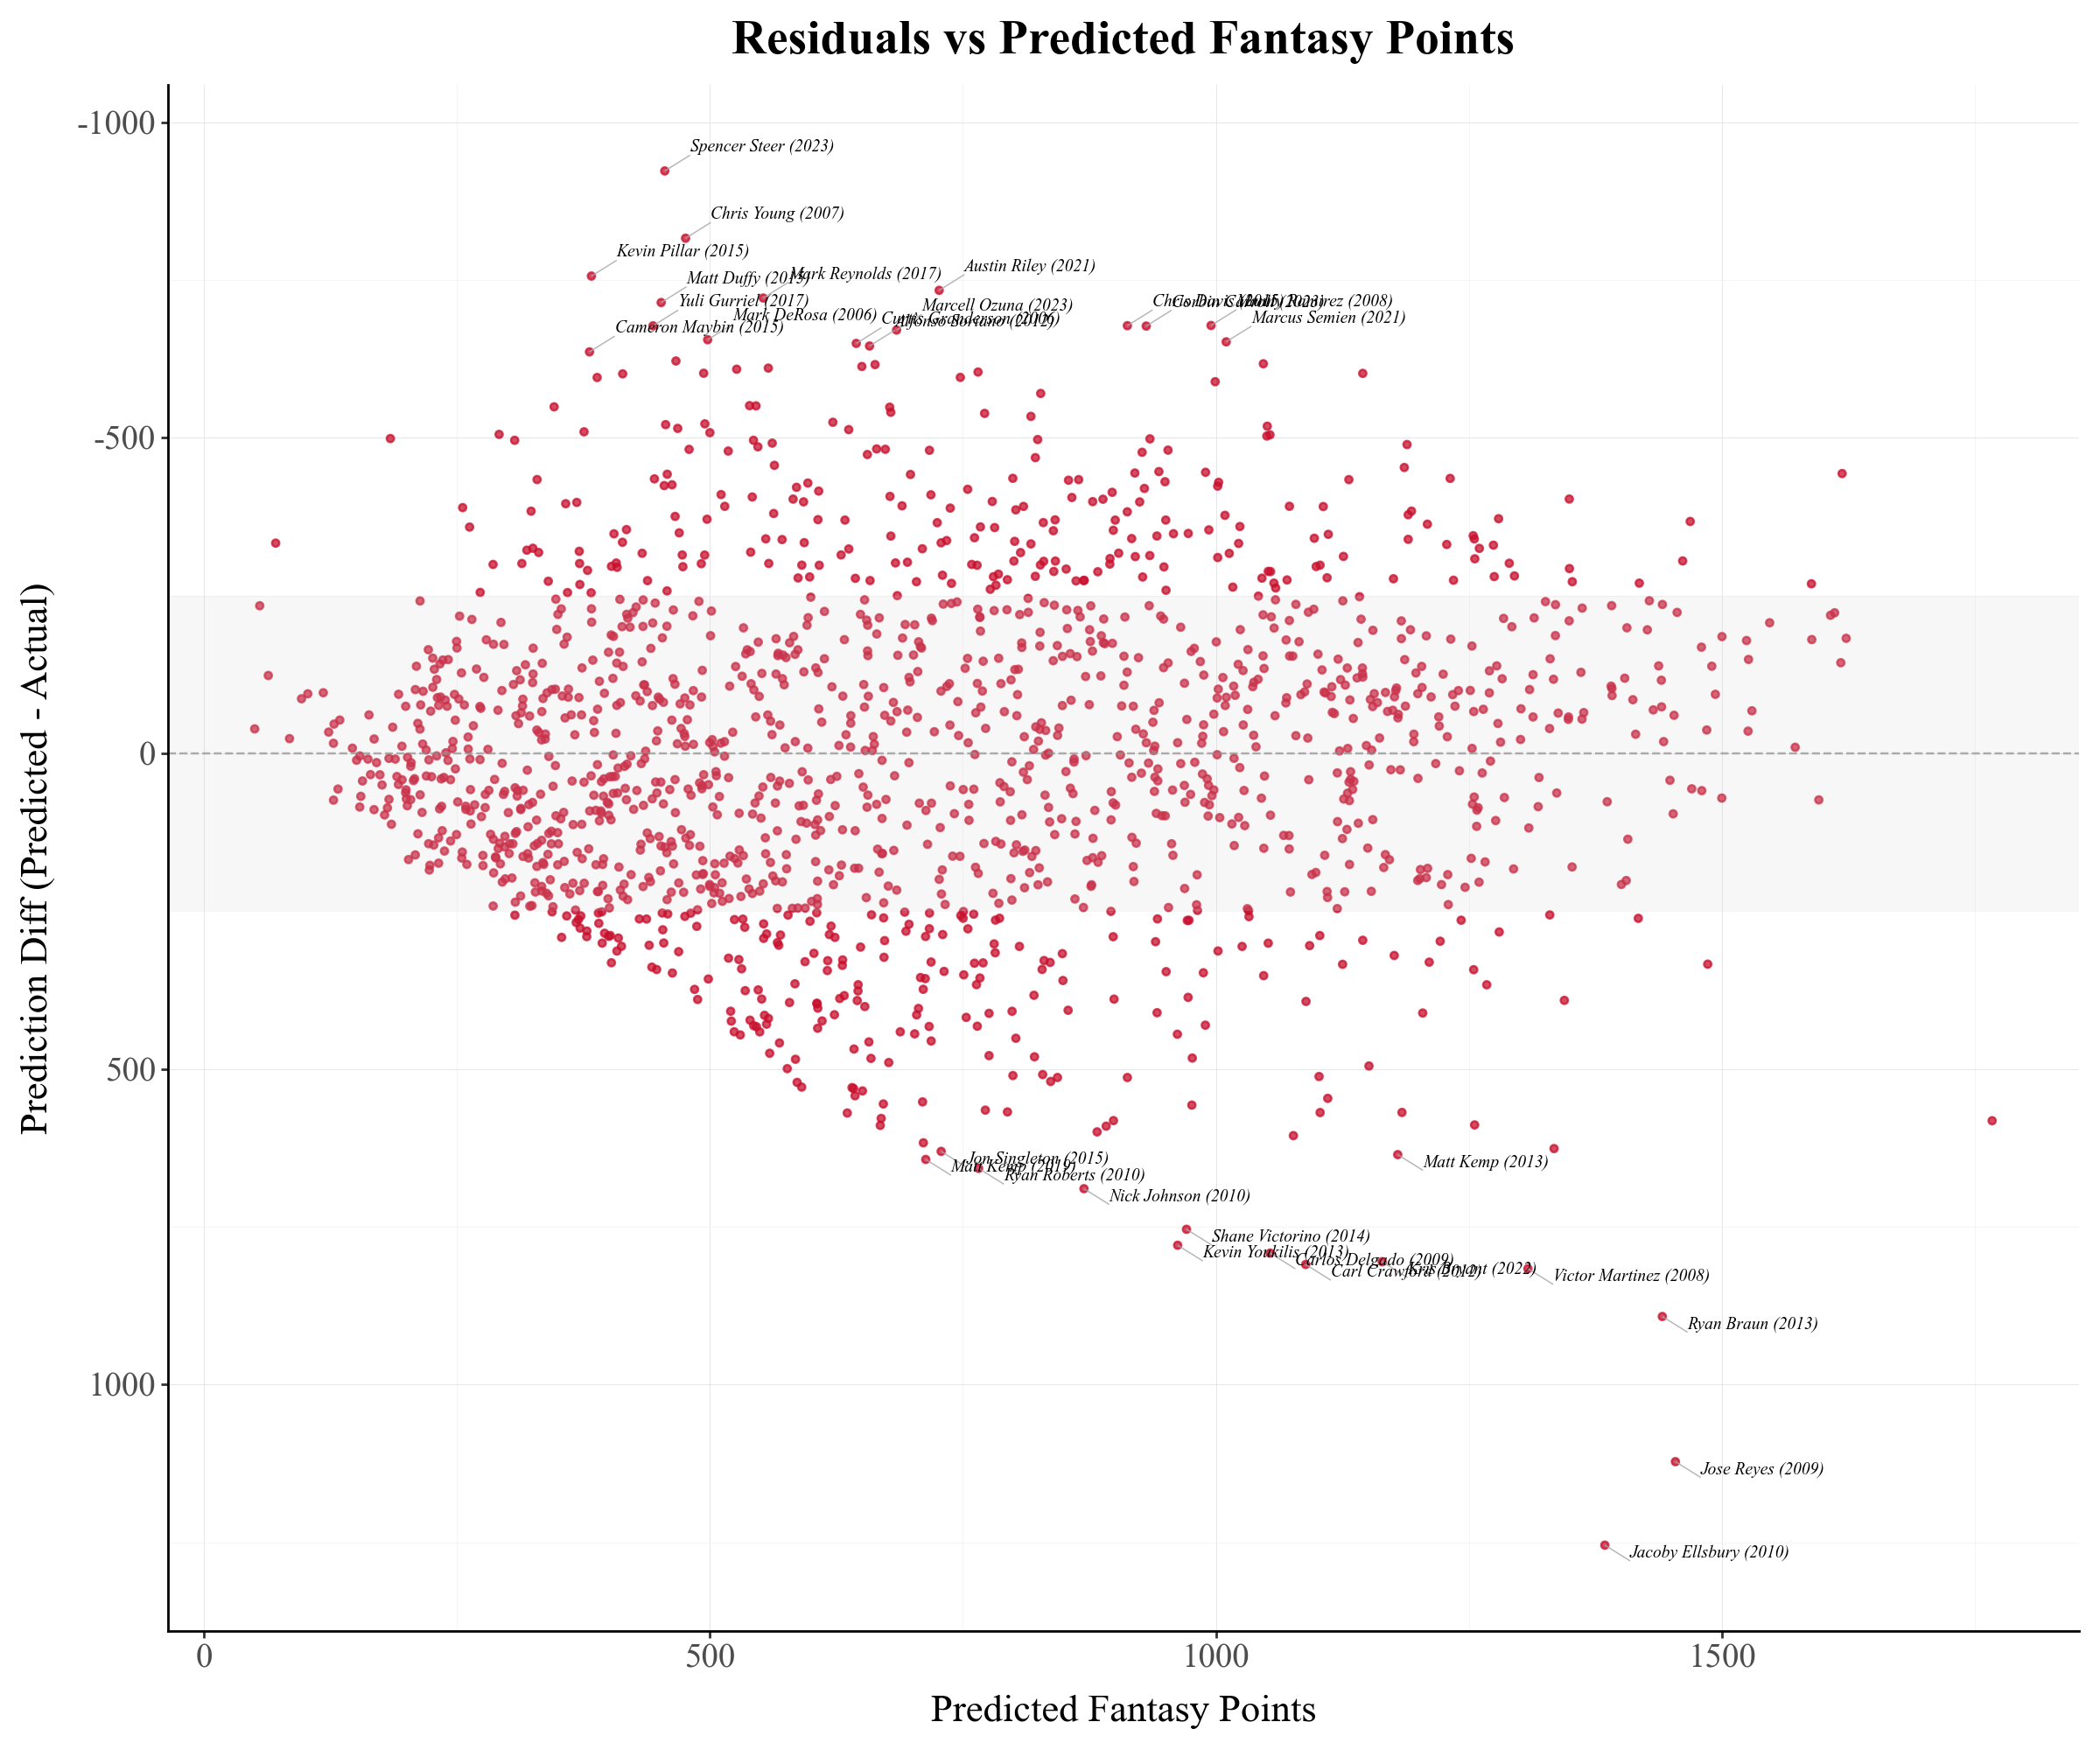

In [160]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

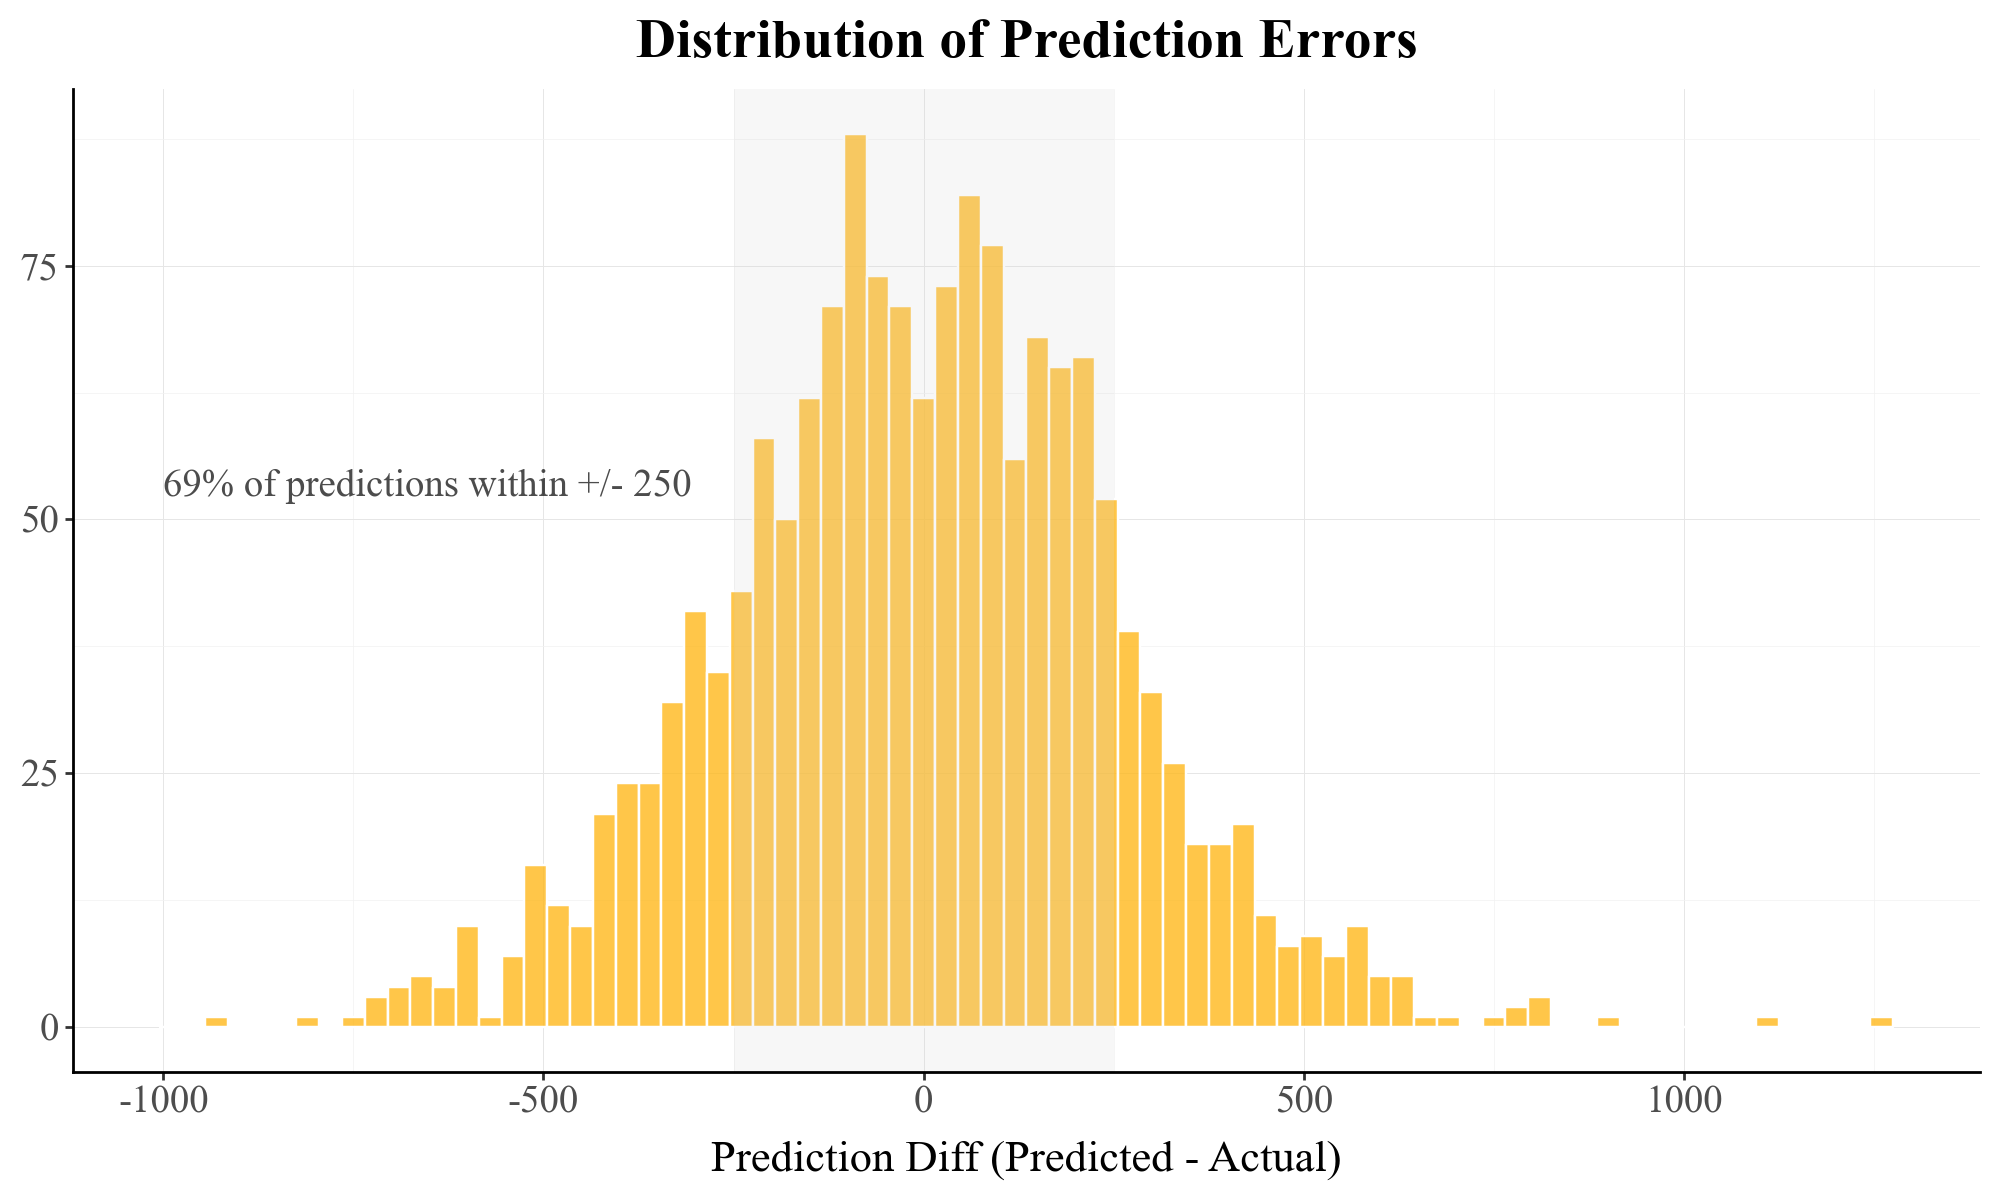

In [161]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=30,
    x_annotate=-1000,    # custom annotation position
    y_annotate=55,      # custom annotation position
)
p3.show()

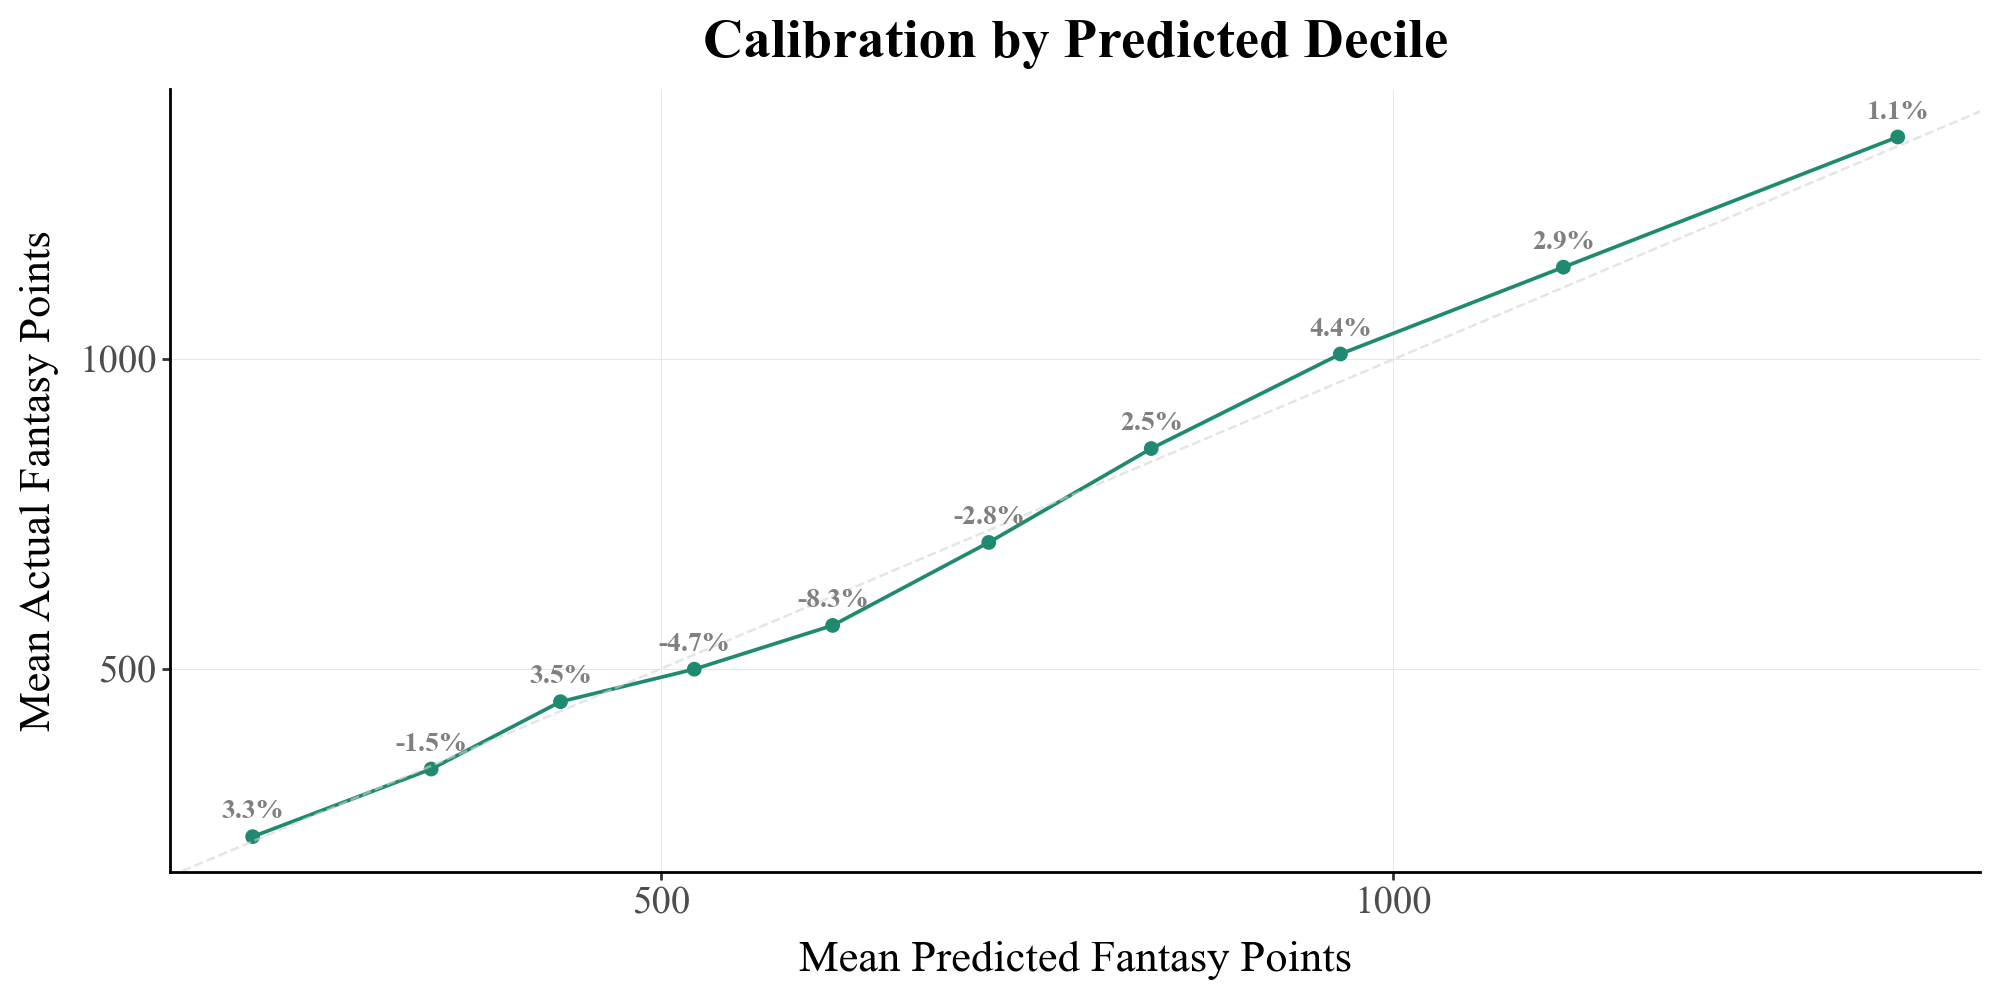

In [162]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating Pitching Model

# Creating baseline pitching predictions

In [163]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df, random_state=42022)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 173.097 | MAE: 127.297 | R^2: 0.621


In [164]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

Name  fantasy_points_future  predicted_fantasy_points  \
980      Max Scherzer                 1464.6               1296.412720   
1126      CC Sabathia                 1369.0               1262.799438   
1329       Jon Lester                  972.6               1216.305420   
414      Max Scherzer                 1316.6               1207.669312   
685   Felix Hernandez                 1165.6               1199.170898   
...               ...                    ...                       ...   
386        Ron Flores                   75.6                 47.988190   
1160     Cody Stashak                   86.0                 34.791401   
350    Kelvin Jimenez                   60.0                 34.759109   
68     Ashton Goudeau                   65.3                 25.570297   
775       Cody Martin                   92.6                 22.133162   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
980       -168.187280     168.187280    2017   32          1316.6  
1126      -106.200562     106.200562    2007   26          1187.0  
1329       243.705420     243.705420    2010   26          1169.0  
414       -108.930688     108.930688    2016   31          1411.3  
685         33.570898      33.570898    2010   24          1319.6  
...               ...            ...     ...  ...             ...  
386        -27.611810      27.611810    2006   26           119.6  
1160       -51.208599      51.208599    2019   25           123.0  
350        -25.240891      25.240891    2007   26           108.0  
68         -39.729703      39.729703    2021   28           130.3  
775        -70.466838      70.466838    2015   25           100.6  

[1525 rows x 8 columns]

# Pitching Predictions

In [165]:
# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=45,
    random_state=42020,
    id_cols=["IDfg"],
    max_depth_choices=None,
)

100%|██████████| 45/45 [03:10<00:00,  4.24s/trial, best loss: 172.48493988836756]
Best Parameters: {'learning_rate': 0.033632719203781254, 'max_leaves': 8, 'grow_policy': 'lossguide', 'max_depth': 0, 'subsample': 0.9927486004110888, 'colsample_bytree': 0.7771595510884565, 'min_child_weight': 0.7607711597006233, 'reg_lambda': 0.0005991572642341685, 'reg_alpha': 0.0020922450750922384, 'gamma': 0.06439378788784558}
[Best trial @ val] optimized=rmse | RMSE=172.485 | MAE=126.916 | ASYM=37552.255


In [166]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=4202022,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 312
[Val] RMSE: 173.293 | MAE: 127.806 | R^2: 0.621 | ASYM: 37838.969
[Test] RMSE: 168.324 | MAE: 124.284 | R^2: 0.641 | ASYM: 35796.436


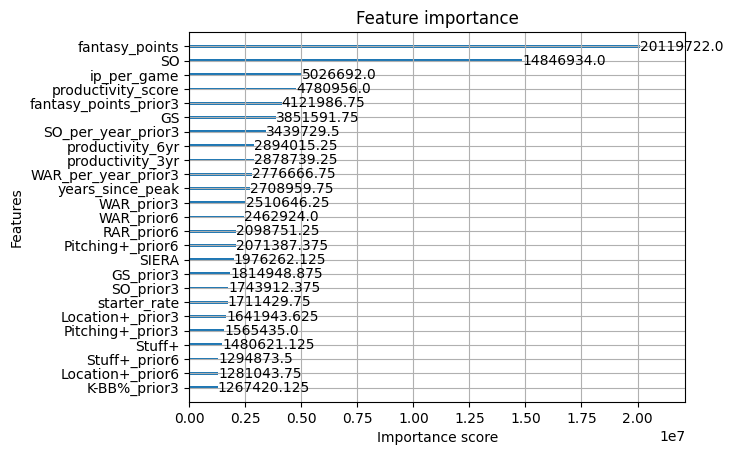

In [167]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=25)
plt.show()

In [168]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results)

Name  fantasy_points_future  predicted_fantasy_points  \
1126      CC Sabathia                 1369.0               1225.728638   
980      Max Scherzer                 1464.6               1200.974365   
685   Felix Hernandez                 1165.6               1186.756226   
410         Cliff Lee                 1309.6               1182.715820   
1104  Felix Hernandez                 1193.0               1178.127319   
...               ...                    ...                       ...   
68     Ashton Goudeau                   65.3                 84.329742   
877     Kohei Arihara                   44.0                 83.686073   
1158       Brad Mills                   53.3                 77.075363   
1132  Stefan Crichton                  136.0                 71.457367   
1160     Cody Stashak                   86.0                 57.955837   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
1126      -143.271362     143.271362    2007   26          1187.0  
980       -263.625635     263.625635    2017   32          1316.6  
685         21.156226      21.156226    2010   24          1319.6  
410       -126.884180     126.884180    2010   31          1026.3  
1104       -14.872681      14.872681    2011   25          1165.6  
...               ...            ...     ...  ...             ...  
68          19.029742      19.029742    2021   28           130.3  
877         39.686073      39.686073    2021   28           112.6  
1158        23.775363      23.775363    2010   25            83.3  
1132       -64.542633      64.542633    2019   27           158.3  
1160       -28.044163      28.044163    2019   25           123.0  

[1525 rows x 8 columns]

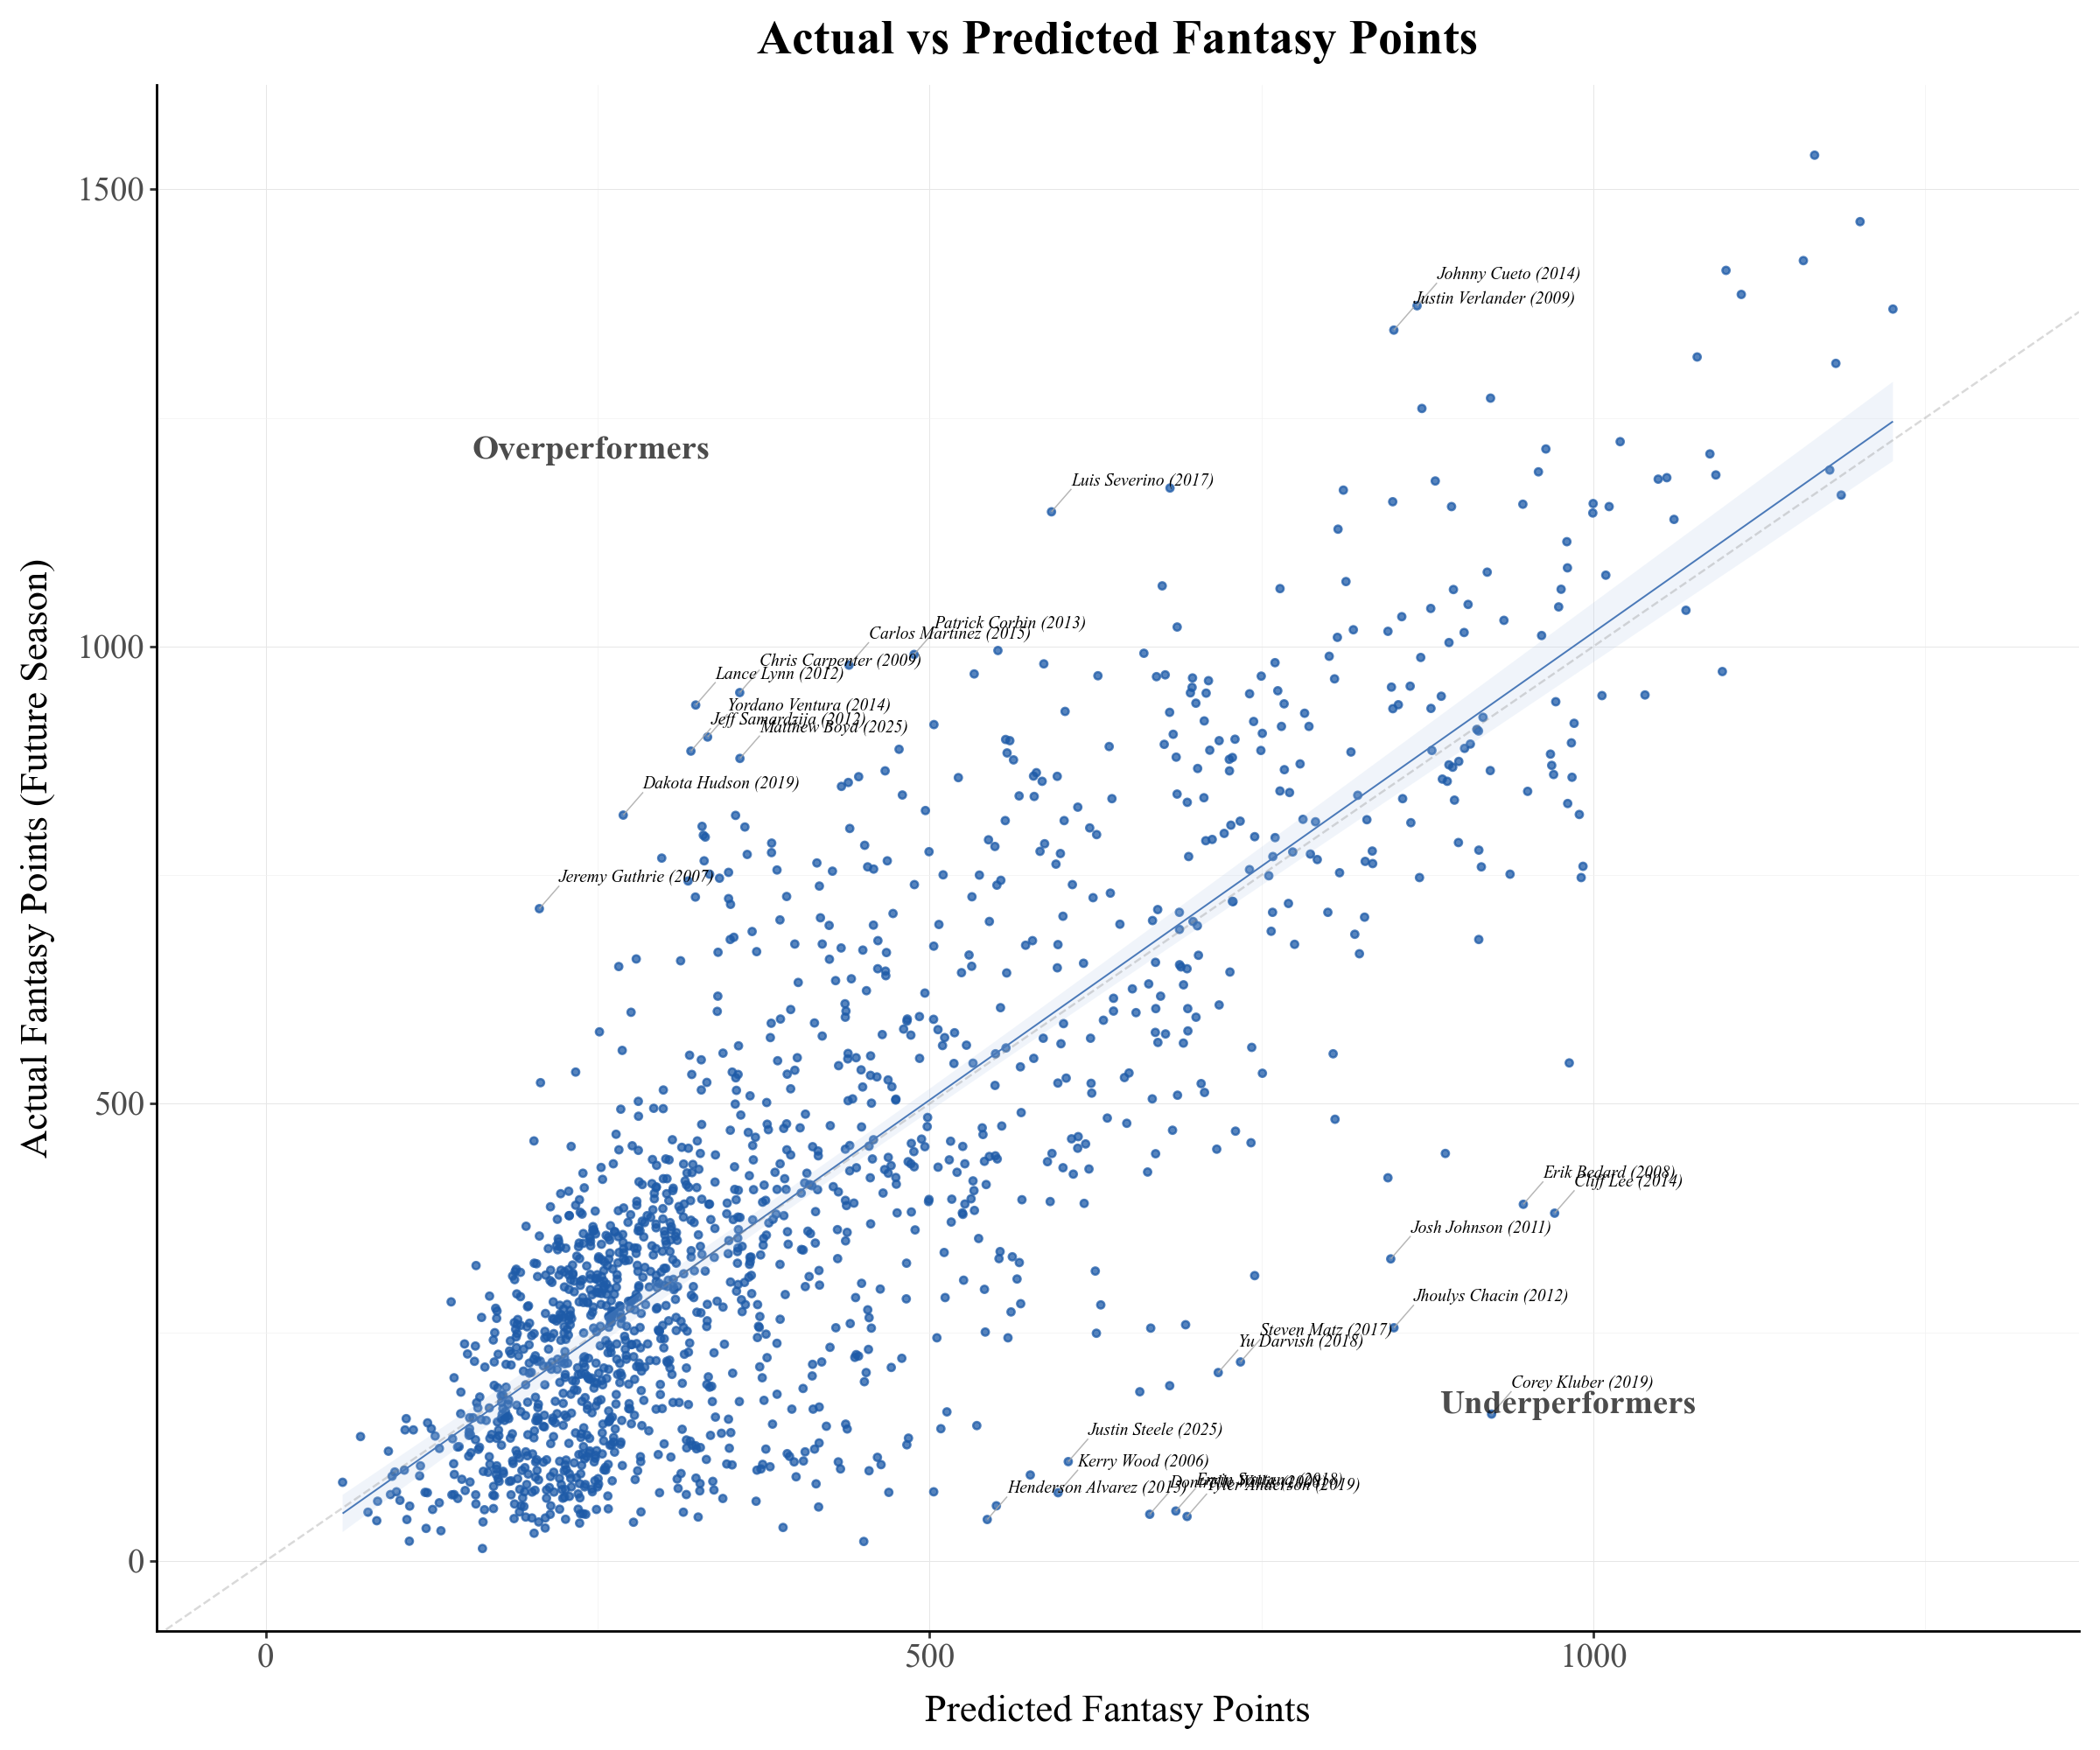

In [169]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

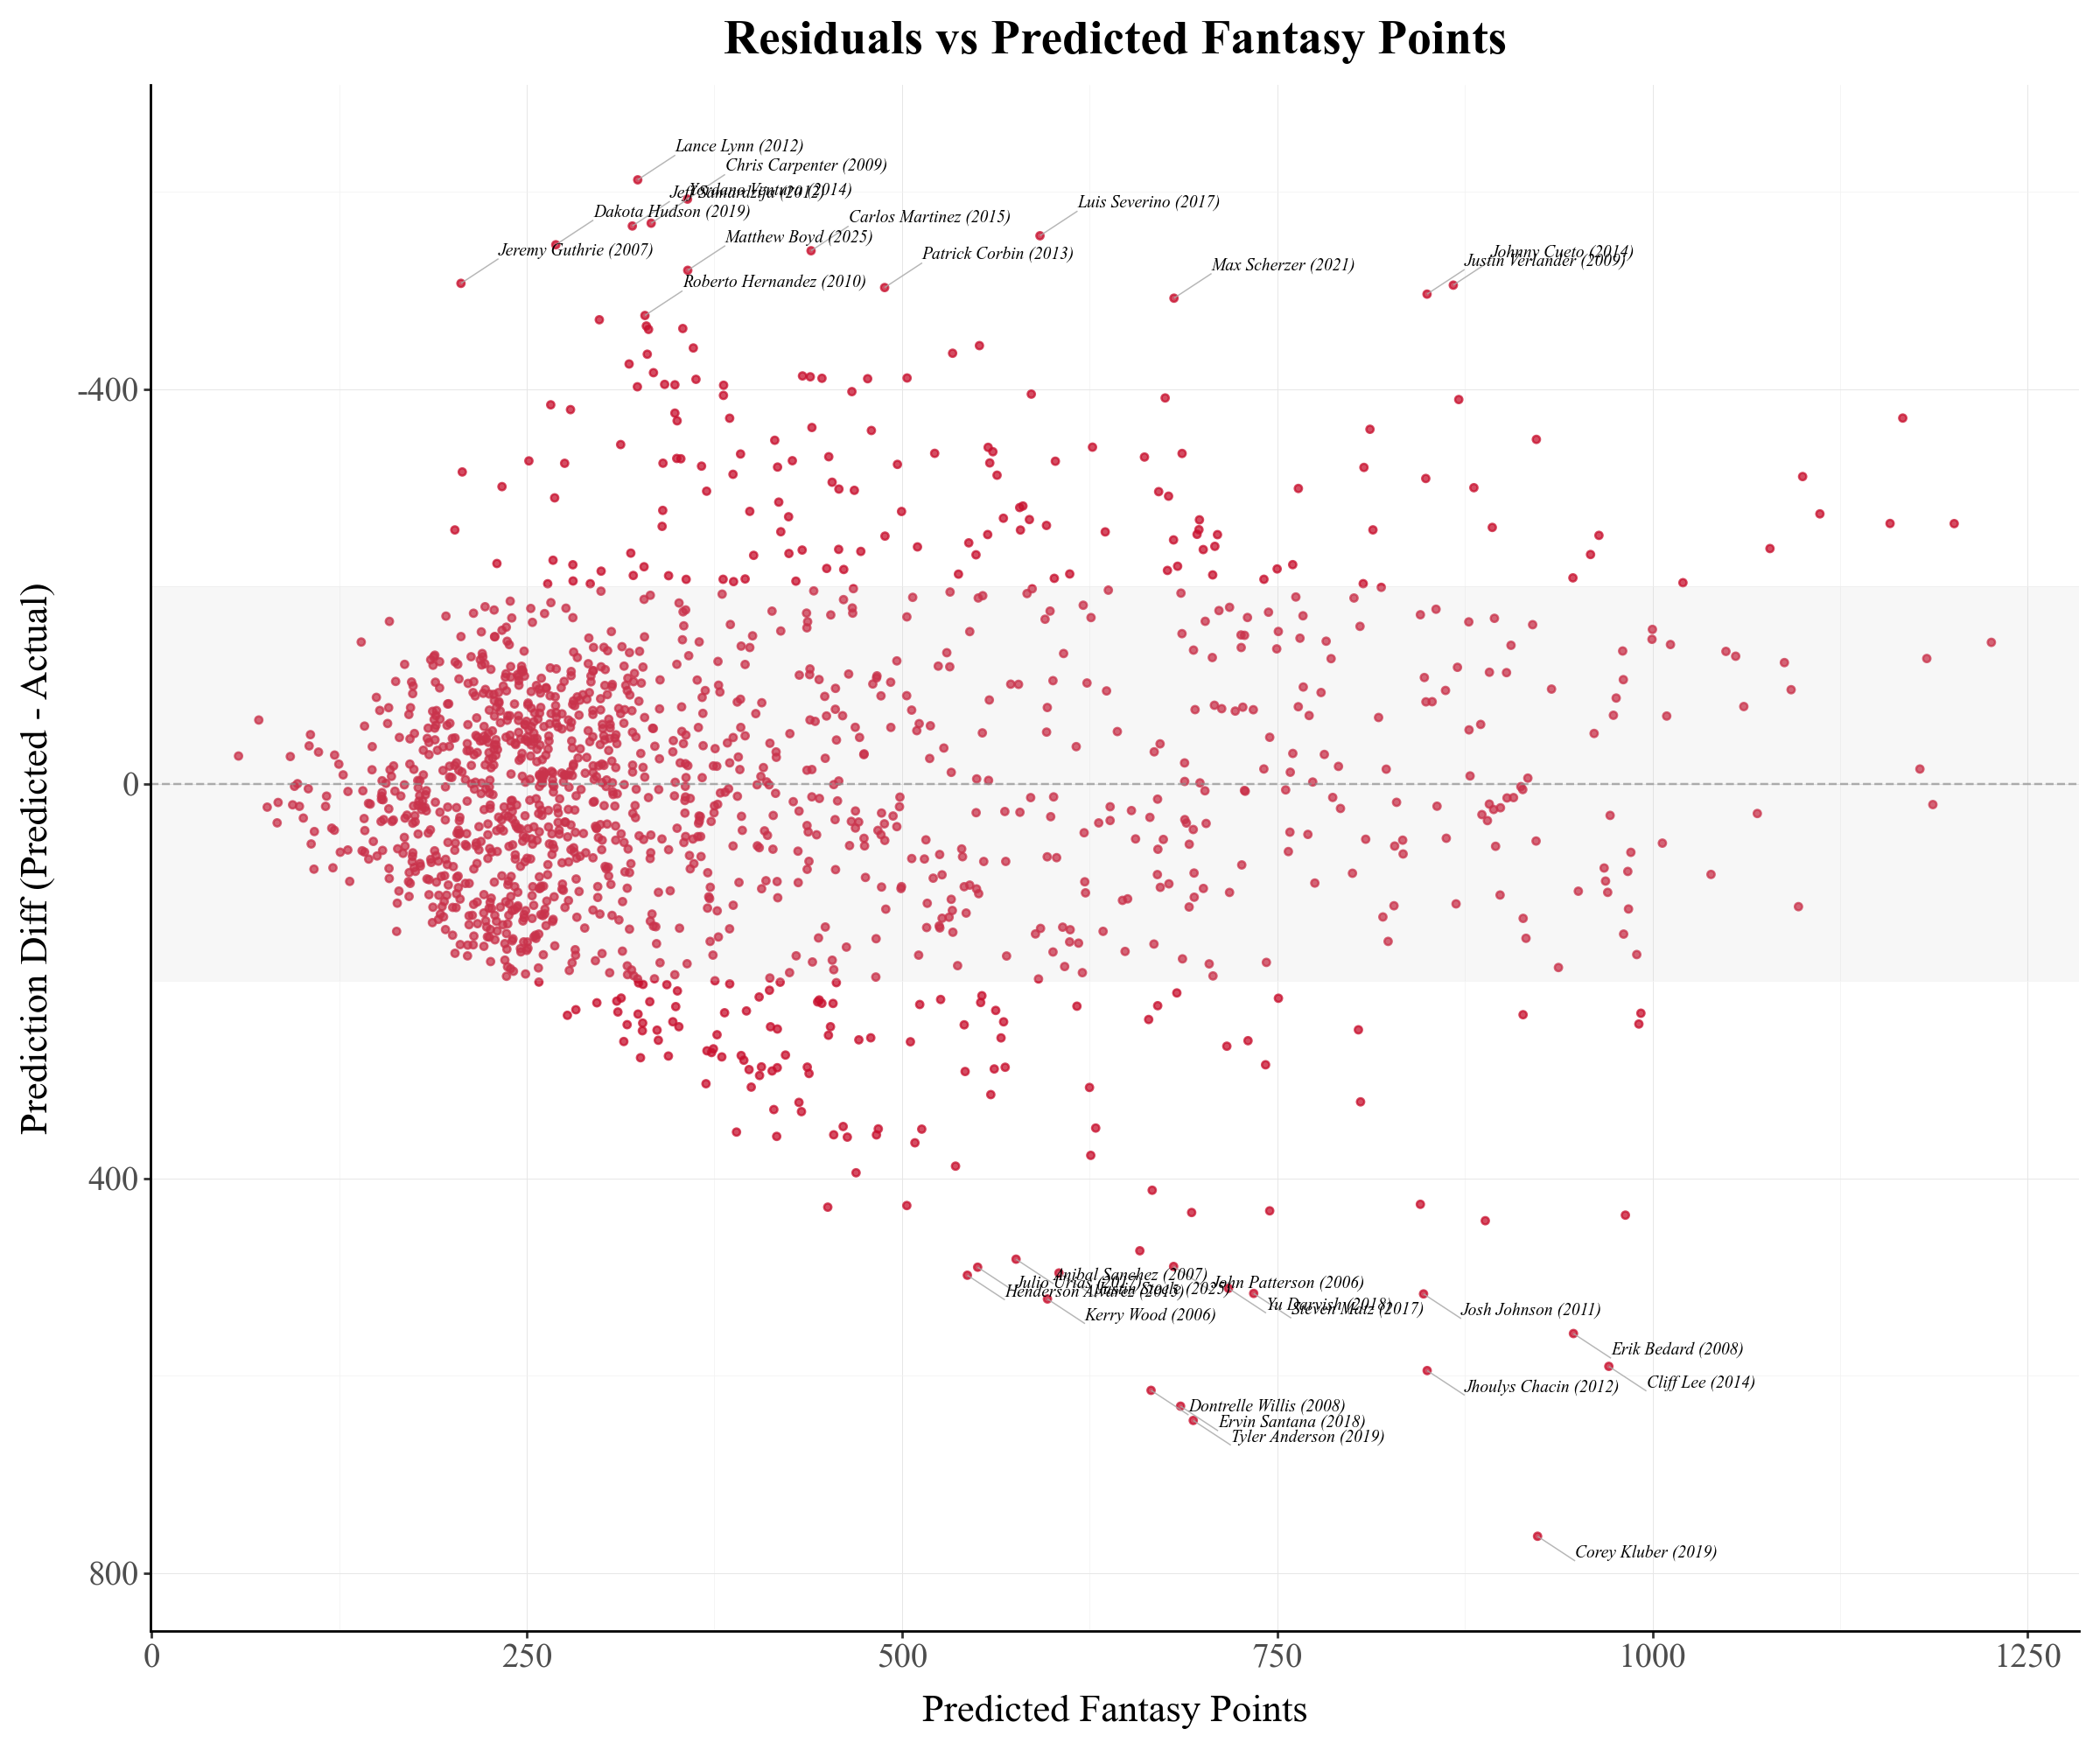

In [170]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=200,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

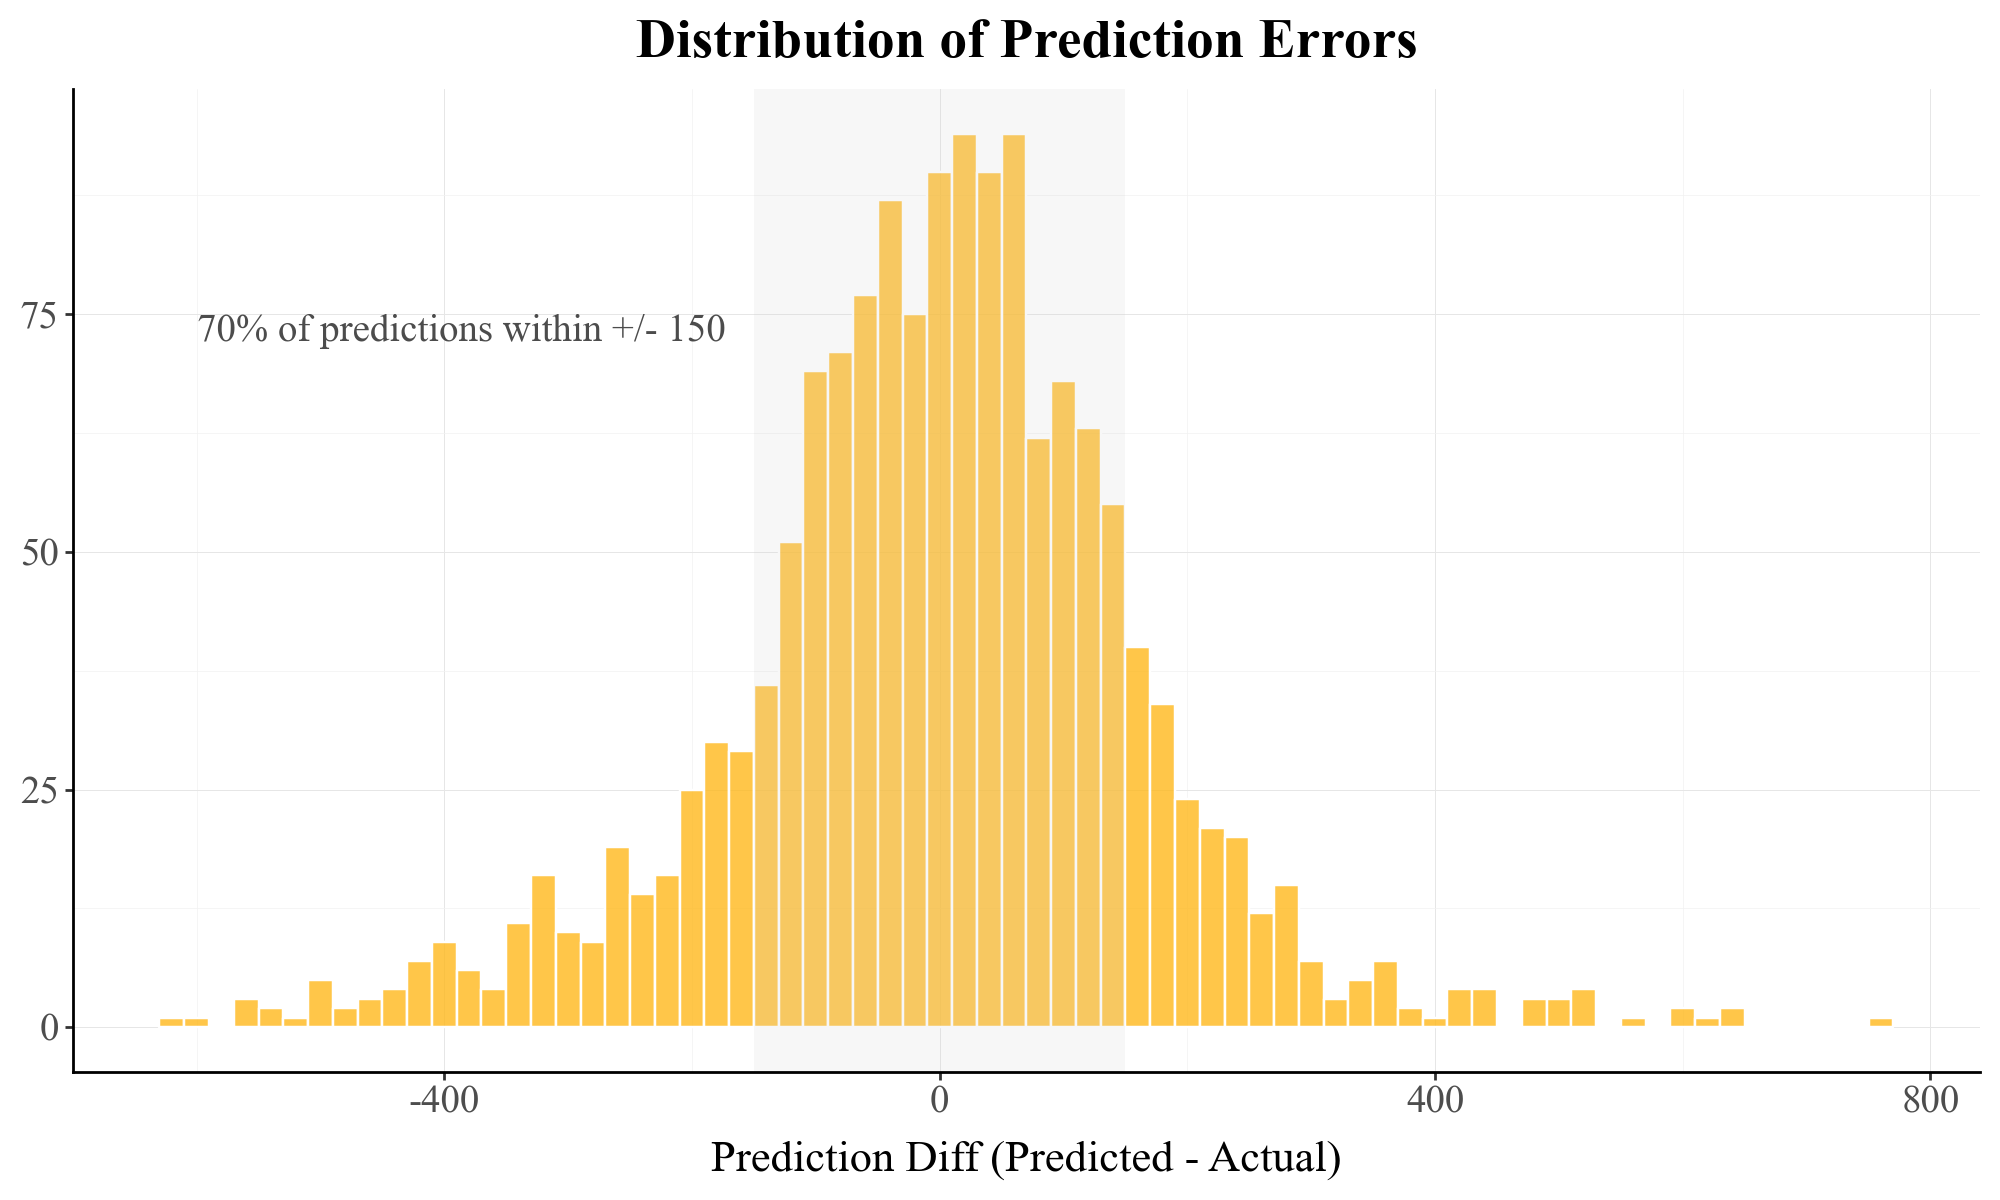

In [171]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=150,
    binwidth=20,
    x_annotate=-600,    # custom annotation position
    y_annotate=75,      # custom annotation position
)
p3.show()

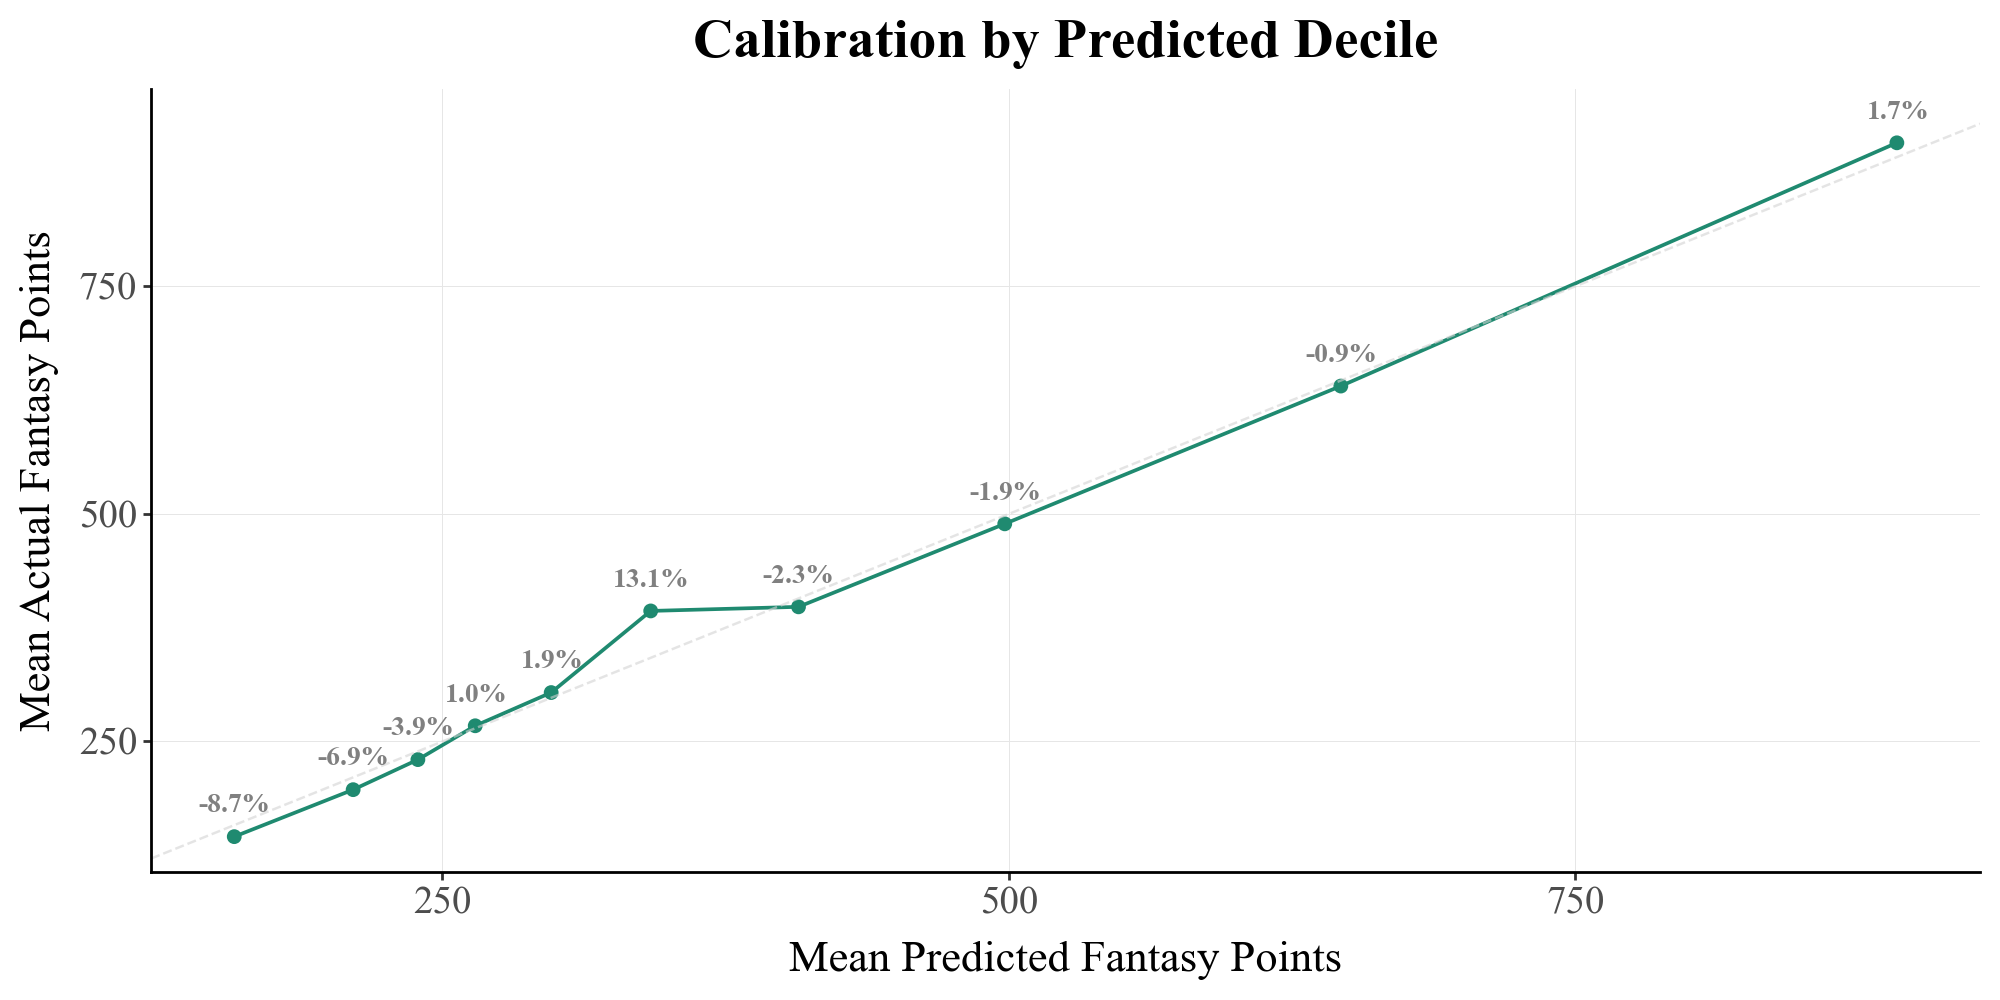

In [172]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [173]:
# Dropping fantasy_points_future from prediction dataframes
batting_pred = batting_pred.drop(columns=['fantasy_points_future'])
pitching_pred = pitching_pred.drop(columns=['fantasy_points_future'])

# Making predictions for the upcoming season
batting_predictions = batting_model.predict(batting_pred.drop(columns=['IDfg', 'Name']))
pitching_predictions = pitching_model.predict(pitching_pred.drop(columns=['IDfg', 'Name']))

In [174]:
batting_pred['fantasy_points_pred'] = batting_predictions
pitching_pred['fantasy_points_pred'] = pitching_predictions

batting_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)  

In [175]:
display(batting_pred)

IDfg  Season             Name  Age    G   AB    H  1B  2B  3B  ...  \
9180   15640    2025      Aaron Judge   33  152  541  179  94  30   2  ...   
10328  19755    2025    Shohei Ohtani   30  158  611  172  83  25   9  ...   
9457   16478    2025   Kyle Schwarber   32  162  604  145  64  23   2  ...   
10491  20123    2025        Juan Soto   26  160  577  152  88  20   1  ...   
11052  25878    2025   Corbin Carroll   24  143  564  146  66  32  17  ...   
...      ...     ...              ...  ...  ...  ...  ...  ..  ..  ..  ...   
10999  25467    2025   Will Robertson   27   27   70    9   8   1   0  ...   
11271  29524    2025   Bryce Teodosio   26   50  138   28  18   7   2  ...   
10332  19802    2025    Jhonny Pereda   29   30   69   17  11   6   0  ...   
11301  29704    2025  Braxton Fulford   26   38  108   23  15   5   2  ...   
10997  25434    2025      Will Wilson   26   34   78   15  11   4   0  ...   

       H_per_year_prior3  HR_per_year_prior3  SB_per_year_prior3  \
9180          152.333333           49.333333            8.333333   
10328         173.333333           51.000000           33.000000   
9457          134.000000           47.000000            5.000000   
10491         158.000000           39.666667           19.000000   
11052         147.666667           26.000000           40.333333   
...                  ...                 ...                 ...   
10999           9.000000            0.000000            0.000000   
11271          29.000000            1.000000            7.000000   
10332          26.000000            0.000000            0.000000   
11301          23.000000            1.000000            1.000000   
10997          15.000000            0.000000            2.000000   

       BB_per_year_prior3  SO_per_year_prior3  WAR_per_year_prior3  \
9180           115.000000          153.666667             8.733333   
10328           93.666667          164.000000             7.666667   
9457           113.333333          203.000000             3.033333   
10491          129.333333          128.333333             6.766667   
11052           65.666667          136.000000             5.400000   
...                   ...                 ...                  ...   
10999            2.000000           27.000000            -0.800000   
11271            5.000000           52.000000             0.400000   
10332            8.000000           31.000000             0.100000   
11301            7.000000           36.000000            -0.500000   
10997            7.000000           34.000000            -0.400000   

       AB_growth_recent  G_growth_recent  player_tier_recent  \
9180          52.000000        13.333333                star   
10328         29.666667         7.333333                star   
9457          16.666667         4.666667           above_avg   
10491          3.333333         0.333333                star   
11052         -8.666667        -9.000000                star   
...                 ...              ...                 ...   
10999          0.000000         0.000000         replacement   
11271        -12.000000        -5.000000         replacement   
10332        -39.000000       -20.000000         replacement   
11301          0.000000         0.000000         replacement   
10997          0.000000         0.000000         replacement   

       fantasy_points_pred  
9180           1682.740234  
10328          1644.869629  
9457           1471.864624  
10491          1426.719116  
11052          1410.078857  
...                    ...  
10999           139.515594  
11271           135.068329  
10332           132.807770  
11301           129.939072  
10997            83.199547  

[537 rows x 204 columns]

In [176]:
display(pitching_pred)

IDfg  Season                Name  Age   G  GS  Pitches  Strikes   W  \
10615  22267    2025        Tarik Skubal   28  31  31     2849     2003  13   
11004  27463    2025     Garrett Crochet   26  32  32     3151     2114  18   
6616   10310    2025        Zack Wheeler   35  24  24     2394     1549  10   
9510   17995    2025          Logan Webb   28  34  34     3282     2165  15   
10374  20778    2025  Cristopher Sanchez   28  32  32     2897     1941  13   
...      ...     ...                 ...  ...  ..  ..      ...      ...  ..   
11225  31533    2025      Victor Mederos   24   5   3      314      183   0   
10424  21189    2025       Brooks Kriske   31  16   0      381      220   0   
11228  31612    2025    Carson Palmquist   24   9   7      705      417   0   
6841   11121    2025      Casey Lawrence   37   6   0      276      179   1   
10588  22200    2025        Ryan Rolison   27  31   1      678      430   1   

       WAR  ...  SO_per_year_prior3  BB_per_year_prior3  HR_per_year_prior3  \
10615  6.6  ...          190.333333           27.333333           12.333333   
11004  5.8  ...          158.666667           30.666667           14.333333   
6616   4.0  ...          210.333333           41.333333           19.666667   
9510   5.5  ...          196.666667           42.333333           15.000000   
10374  6.4  ...          153.666667           34.666667           13.000000   
...    ...  ...                 ...                 ...                 ...   
11225 -0.3  ...            7.333333            7.000000            1.666667   
10424  0.0  ...            8.000000            6.333333            1.000000   
11228 -0.6  ...           27.000000           25.000000           10.000000   
6841   0.0  ...            9.000000            3.666667            3.000000   
10588 -0.7  ...           25.000000           20.000000           11.000000   

       ER_per_year_prior3  WAR_per_year_prior3  G_growth_recent  \
10615           41.333333             5.300000         5.333333   
11004           40.666667             3.433333         6.333333   
6616            59.666667             5.100000        -5.333333   
9510            77.000000             4.966667         0.666667   
10374           53.666667             4.266667         4.666667   
...                   ...                  ...              ...   
11225            8.000000            -0.133333         1.000000   
10424            6.000000            -0.033333         9.333333   
11228           34.000000            -0.600000         0.000000   
6841             9.333333            -0.133333        -1.000000   
10588           33.000000            -0.700000         0.000000   

       IP_growth_recent  GS_growth_recent  player_tier_recent  \
10615         39.366667          5.333333                star   
11004         83.766667         10.666667           above_avg   
6616         -31.200000         -5.333333                star   
9510          -2.066667          0.666667                star   
10374         41.000000          5.000000                star   
...                 ...               ...                 ...   
11225          8.633333          2.000000         replacement   
10424          9.933333          0.000000         replacement   
11228          0.000000          0.000000         replacement   
6841           2.200000          0.000000         replacement   
10588          0.000000          0.000000         replacement   

       fantasy_points_pred  
10615           966.595764  
11004           903.410889  
6616            897.639099  
9510            866.431030  
10374           860.770691  
...                    ...  
11225            84.903976  
10424            83.090202  
11228            82.459587  
6841             80.025597  
10588            76.005409  

[590 rows x 204 columns]

In [177]:
batting_pred = split_name(batting_pred, 'Name')
pitching_pred = split_name(pitching_pred, 'Name')

In [178]:
# Creating combined batting dataframe
batting_final = combine_projections(batting_pred, batting_projections)

Duplicate rows found:


IDfg  Season       Name   Age      G     AB     H    1B    2B   3B  \
449  13301.0  2025.0  Max Muncy  34.0  100.0  313.0  76.0  45.0  10.0  2.0   
450  13301.0  2025.0  Max Muncy  34.0  100.0  313.0  76.0  45.0  10.0  2.0   
451  29779.0  2025.0  Max Muncy  22.0   63.0  206.0  44.0  28.0   7.0  0.0   
452  29779.0  2025.0  Max Muncy  22.0   63.0  206.0  44.0  28.0   7.0  0.0   

     ...  WAR_per_year_prior3  AB_growth_recent  G_growth_recent  \
449  ...                  2.6             -31.0        -2.666667   
450  ...                  2.6             -31.0        -2.666667   
451  ...                 -0.4               0.0         0.000000   
452  ...                 -0.4               0.0         0.000000   

     player_tier_recent  fantasy_points_pred  first_name  last_name  Team  \
449           above_avg           802.165955         max      muncy   LAD   
450           above_avg           802.165955         max      muncy   ATH   
451         replacement           254.138458         max      muncy   LAD   
452         replacement           254.138458         max      muncy   ATH   

     Positions  projected_fantasy_points  
449         3B                     890.0  
450   2B,3B,SS                     665.0  
451         3B                     890.0  
452   2B,3B,SS                     665.0  

[4 rows x 209 columns]

In [179]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

display(batting_final)

IDfg  Season            Name   Age      G     AB      H    1B    2B  \
0        NaN     NaN             NaN   NaN    NaN    NaN    NaN   NaN   NaN   
1    15640.0  2025.0     Aaron Judge  33.0  152.0  541.0  179.0  94.0  30.0   
2        NaN     NaN             NaN   NaN    NaN    NaN    NaN   NaN   NaN   
3    19844.0  2025.0    Abraham Toro  28.0   77.0  259.0   62.0  42.0  13.0   
4    27962.0  2025.0    Adael Amador  22.0   41.0  113.0   20.0  12.0   7.0   
..       ...     ...             ...   ...    ...    ...    ...   ...   ...   
682  31562.0  2025.0    Zach Dezenzo  25.0   34.0   98.0   24.0  16.0   6.0   
683  19392.0  2025.0  Zach McKinstry  30.0  144.0  452.0  117.0  71.0  23.0   
684  31347.0  2025.0       Zach Neto  24.0  128.0  502.0  129.0  73.0  29.0   
685  29766.0  2025.0      Zack Gelof  25.0   30.0   92.0   16.0  11.0   3.0   
686  19562.0  2025.0      Zack Short  30.0   22.0   50.0   11.0   7.0   2.0   

       3B  ...  WAR_per_year_prior3  AB_growth_recent  G_growth_recent  \
0     NaN  ...                  NaN               NaN              NaN   
1     2.0  ...             8.733333         52.000000        13.333333   
2     NaN  ...                  NaN               NaN              NaN   
3     0.0  ...             0.100000         54.333333        17.000000   
4     0.0  ...            -1.300000        -35.000000       -10.000000   
..    ...  ...                  ...               ...              ...   
682   0.0  ...            -0.200000        -62.000000       -19.000000   
683  11.0  ...             1.766667         47.666667         7.333333   
684   1.0  ...             2.600000         57.666667         5.666667   
685   0.0  ...             1.266667       -194.333333       -49.000000   
686   0.0  ...            -0.166667        -63.666667       -36.666667   

     player_tier_recent  fantasy_points_pred  first_name  last_name  Team  \
0                   NaN                  NaN        a.j.   vukovich   ARI   
1                  star          1682.740234       aaron      judge   NYY   
2                   NaN                  NaN    abimelec      ortiz   TEX   
3           replacement           339.151642     abraham       toro   NaN   
4           replacement           189.922913       adael     amador   COL   
..                  ...                  ...         ...        ...   ...   
682         replacement           199.539963        zach    dezenzo   HOU   
683                 avg           653.505493        zach  mckinstry   DET   
684           above_avg           964.932129        zach       neto   LAA   
685                 avg           449.093750        zack      gelof   ATH   
686         replacement           227.247528        zack      short   NaN   

       Positions  projected_fantasy_points  
0          3B,LF                      71.0  
1    LF,CF,RF,DH                    1748.0  
2          1B,OF                     104.0  
3            NaN                       NaN  
4             2B                     619.0  
..           ...                       ...  
682        LF,RF                     173.0  
683  3B,SS,LF,RF                     745.0  
684           SS                    1314.0  
685           2B                     220.0  
686          NaN                       NaN  

[685 rows x 209 columns]

In [180]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_pred, pitching_projections)

No duplicate rows found.


In [181]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
# pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

display(pitching_final)

IDfg  Season            Name   Age     G    GS  Pitches  Strikes  \
0    31764.0  2025.0   A.J. Blubaugh  24.0  11.0   3.0    508.0    316.0   
1        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
2        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
3        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
4    23550.0  2025.0     Aaron Ashby  27.0  43.0   1.0   1033.0    645.0   
..       ...     ...             ...   ...   ...   ...      ...      ...   
895  20349.0  2025.0      Zack Kelly  30.0  28.0   0.0    583.0    383.0   
896  15823.0  2025.0    Zack Littell  29.0  32.0  32.0   2789.0   1868.0   
897  10310.0  2025.0    Zack Wheeler  35.0  24.0  24.0   2394.0   1549.0   
898  25703.0  2025.0        Zak Kent  27.0  12.0   0.0    308.0    187.0   
899  31827.0  2025.0  Zebby Matthews  25.0  16.0  16.0   1353.0    895.0   

        W  WAR  ...  G_growth_recent  IP_growth_recent  GS_growth_recent  \
0     3.0  0.1  ...         0.000000          0.000000          0.000000   
1     NaN  NaN  ...              NaN               NaN               NaN   
2     NaN  NaN  ...              NaN               NaN               NaN   
3     NaN  NaN  ...              NaN               NaN               NaN   
4     5.0  1.2  ...        24.000000         34.533333          0.000000   
..    ...  ...  ...              ...               ...               ...   
895   1.0  0.4  ...        -0.333333          1.400000         -1.000000   
896  10.0  1.5  ...         2.333333         41.866667          7.000000   
897  10.0  4.0  ...        -5.333333        -31.200000         -5.333333   
898   1.0  0.1  ...         0.000000          0.000000          0.000000   
899   5.0  1.4  ...         3.500000         20.600000          3.500000   

     player_tier_recent  fantasy_points_pred  first_name  last_name  Team  \
0           replacement           185.487503        a.j.   blubaugh   NaN   
1                   NaN                  NaN        a.j.     causey    KC   
2                   NaN                  NaN        a.j.     minter   NYM   
3                   NaN                  NaN        a.j.        puk   ARI   
4           replacement           304.554443       aaron      ashby   MIL   
..                  ...                  ...         ...        ...   ...   
895         replacement           182.833984        zack      kelly   BOS   
896                 avg           413.968689        zack    littell   NaN   
897                star           897.639099        zack    wheeler   PHI   
898         replacement            95.090172         zak       kent   TEX   
899         replacement           237.007217       zebby   matthews   MIN   

     Positions  projected_fantasy_points  
0          NaN                       NaN  
1            P                      83.0  
2           RP                     302.4  
3           RP                     167.8  
4           RP                     308.7  
..         ...                       ...  
895      SP,RP                     247.5  
896         SP                     707.3  
897         SP                     729.6  
898         RP                     206.2  
899         SP                     599.9  

[900 rows x 209 columns]

In [182]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

In [183]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
batting_final['Name'] = batting_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
batting_final = batting_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "DH" for hitters
batting_final['Positions'] = batting_final['Positions'].fillna('DH')

# Taking the first value in the Positions column as the player's primary position
batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

# Replacing LF, CF, and RF positions with "OF" for alignment with standard rankings
batting_final['Positions'] = batting_final['Positions'].replace({'LF': 'OF', 'CF': 'OF', 'RF': 'OF'})

# Renaming Positions to Position
batting_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [184]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
pitching_final['Name'] = pitching_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
pitching_final = pitching_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_final['Positions'] = pitching_final['Positions'].fillna('SP')

# Taking the first value in the Positions column as the player's primary position
pitching_final['Positions'] = pitching_final['Positions'].apply(get_value_before_comma)

# Renaming Positions to Position
pitching_final.rename(columns={'Positions': 'Position'}, inplace=True)

# Finalizing Predictions & Creating Relative Positional Value Scores

In [185]:
# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])

pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [186]:
# Splitting batting players into infielders and outfielders
batting_final_if = batting_final[batting_final['Position'] != 'OF']
batting_final_of = batting_final[batting_final['Position'] == 'OF']

In [187]:
# Creating final projected score, with 70% weight being placed on predictions and 30% weight being placed on fantasypros projections
# Creating initial player rankings based on final projection
batting_final_if['final_projection'] = (batting_final_if['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_if['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_if['initial_rank'] = batting_final_if['final_projection'].rank(ascending=False)

batting_final_of['final_projection'] = (batting_final_of['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_of['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_of['initial_rank'] = batting_final_of['final_projection'].rank(ascending=False)

pitching_final['final_projection'] = (pitching_final['fantasy_points_pred'] * MODEL_WEIGHT) + (pitching_final['projected_fantasy_points'] * PROJECTION_WEIGHT)
pitching_final['initial_rank'] = pitching_final['final_projection'].rank(ascending=False)

In [200]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [201]:
# Using player pool cutoffs to filter batting and pitching draft pool
batting_final_if = batting_final_if[batting_final_if['initial_rank'] <= batter_pool_if]
batting_final_of = batting_final_of[batting_final_of['initial_rank'] <= batter_pool_of]
pitching_final = pitching_final[pitching_final['initial_rank'] <= pitcher_pool]

In [202]:
batting_final = pd.concat([batting_final_if, batting_final_of])

In [203]:
# Adjusting positional group for select players within the batting_final dataframe to align with 2026 position designations
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Rafael Devers', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Tyler Soderstrom', 'Position'] = 'OF'

batting_final = assign_position_group(batting_final, position_col = 'Position')

pitching_final = assign_position_group(pitching_final, position_col = 'Position')

In [204]:
# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

In [205]:
# Calculating relative positional values & ranking players within position based on projected value
value_df = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.67,
    vorp_scale=1, # VORP scale set to 1, see validation within "estimate_vorp_scale.ipynb"
    dampening_map=POS_DAMPENING_MAP,
)

In [206]:
# Saving value_df to CSV for vorp_scale estimation
# value_df.to_csv('notebooks/value_df.csv', index=False)

# Create Player Value Segments

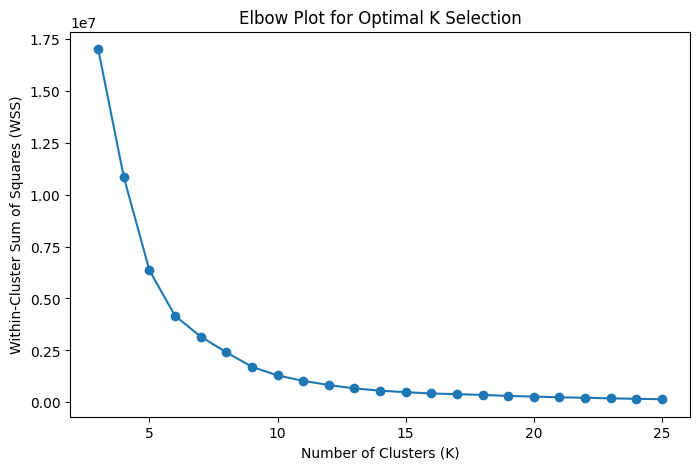

In [207]:
# Evaluating clustering performance on varying K values
determine_optimal_k(value_df, max_k = 25)

In [208]:
# Setting a K of 20 and placing players into relative value tiers
final_df = segment_players(value_df, k = 20)

In [209]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

# Selecting final columns for output
final_df = final_df[['Name', 'Age', 'Team', 'Position', 'position_group', 'fantasy_points_pred', 'projected_fantasy_points', 
                     'final_projection', 'relative_value', 'overall_ranking', 'position_rank', 'player_value_tier']]

In [210]:
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}.csv', index=False)